In [1]:
import helpers as help
load = help.DataBaseLoader(user='postgres', password='Bernie0852', schema='mimiciv_derived')
vitals_df = load['vitalsign']
vitals_df.head()

,subject_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,temperature_site,spo2,glucose
0,10000032,39553978,2180-07-23 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.06,Oral,NaN,NaN
1,10000032,39553978,2180-07-23 14:11:00,NaN,84.0,48.0,56.0,84.0,48.0,56.0,NaN,NaN,None,NaN,NaN
2,10000032,39553978,2180-07-23 14:12:00,91.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,None,NaN,NaN
3,10000032,39553978,2180-07-23 14:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,98.0,NaN
4,10000032,39553978,2180-07-23 14:30:00,93.0,95.0,59.0,67.0,95.0,59.0,67.0,21.0,NaN,None,97.0,NaN


## Heart Rate Data

In [2]:
hr_df = load.query(
    """
    WITH heartrate AS(
	SELECT subject_id, stay_id
	, charttime
	, heart_rate
	FROM vitalsign
	WHERE heart_rate IS NOT NULL
    )
    , count_measurement AS(
        SELECT h.stay_id, COUNT(h.heart_rate) as num
        FROM heartrate h
        GROUP BY h.stay_id
    )
    , filtered AS (
        SELECT stay_id, num
        FROM count_measurement
        WHERE num >= 49
    )
    SELECT v.subject_id, v.stay_id, v.charttime, v.heart_rate
    FROM heartrate v
    INNER JOIN filtered f
        ON v.stay_id = f.stay_id
    """
)
len(hr_df['stay_id'].unique())

36832

## See Trade Off

In [3]:
from tqdm import tqdm
x, y = [], []


In [ ]:
for threshold in tqdm(range(30, 400, 10)):
    hr_df = load.query(
        f"""
        WITH heartrate AS(
        SELECT subject_id, stay_id
        , charttime
        , heart_rate
        FROM vitalsign
        WHERE heart_rate IS NOT NULL
        )
        , count_measurement AS(
            SELECT h.stay_id, COUNT(h.heart_rate) as num
            FROM heartrate h
            GROUP BY h.stay_id
        )
        , filtered AS (
            SELECT stay_id, num
            FROM count_measurement
            WHERE num >= {threshold}
        )
        SELECT v.subject_id, v.stay_id, v.charttime, v.heart_rate
        FROM heartrate v
        INNER JOIN filtered f
            ON v.stay_id = f.stay_id
        """
    )
    if len(hr_df['stay_id'].unique()) == 0:
        break
    x.append(threshold)
    y.append(len(hr_df['stay_id'].unique()))

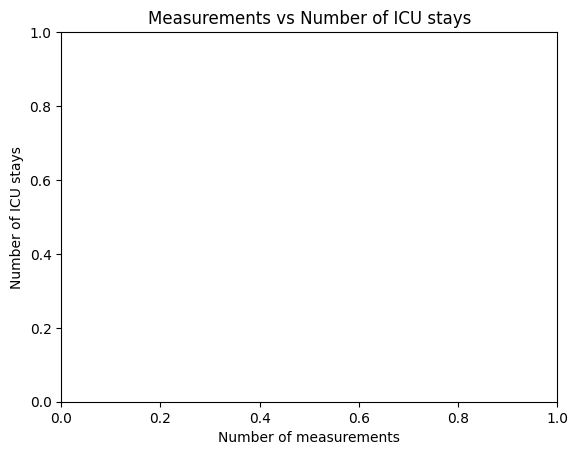

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style()
sns.lineplot(x=x, y=y, marker='s')
plt.title("Measurements vs Number of ICU stays")
plt.xlabel("Number of measurements")
plt.ylabel("Number of ICU stays")
plt.show()

Pick 400

In [5]:
hr_df = load.query(
        f"""
        WITH heartrate AS(
        SELECT subject_id, stay_id
        , charttime
        , heart_rate
        FROM vitalsign
        WHERE heart_rate IS NOT NULL
        )
        , count_measurement AS(
            SELECT h.stay_id, COUNT(h.heart_rate) as num
            FROM heartrate h
            GROUP BY h.stay_id
        )
        , filtered AS (
            SELECT stay_id, num
            FROM count_measurement
            WHERE num >= 400
        )
        SELECT v.subject_id, v.stay_id, v.charttime, v.heart_rate
        FROM heartrate v
        INNER JOIN filtered f
            ON v.stay_id = f.stay_id
        """
    )
len(hr_df['stay_id'].unique())

2158

get all ICU stay IDs

In [6]:
ids = list(hr_df['stay_id'].unique())
ids

[38383343,
 31316840,
 32359580,
 32136798,
 35526828,
 38197705,
 37919901,
 34622731,
 38809220,
 33804579,
 33281088,
 34172975,
 33222233,
 35839507,
 38980177,
 32245180,
 36265401,
 36938927,
 37631738,
 38710393,
 39990093,
 32906693,
 32874601,
 38333165,
 31274661,
 36965545,
 31701999,
 39292081,
 39565767,
 32190450,
 30339307,
 39249300,
 37929889,
 36630531,
 33976285,
 32259031,
 37887738,
 32026882,
 32730436,
 39378505,
 37307878,
 36616884,
 35825770,
 30272416,
 32820625,
 38308794,
 36126597,
 30109460,
 30201512,
 31376532,
 31999886,
 33918239,
 36975538,
 31803488,
 30896750,
 36977059,
 38573575,
 30481610,
 30813888,
 33336719,
 33920408,
 34158968,
 35242188,
 32443482,
 38228907,
 34776044,
 35968919,
 39932818,
 36975675,
 38145046,
 37458704,
 36960534,
 38975964,
 34440488,
 34606617,
 36756755,
 38368971,
 34166660,
 31736067,
 32834587,
 36405803,
 34310308,
 38870879,
 31272962,
 32490594,
 37943127,
 39132344,
 32567783,
 30886536,
 32647330,
 35225810,

Small example on how to make hours consistent (1 hour)
* resampling & interpolation

In [7]:
specific_df = hr_df[hr_df['stay_id'] == 32038864]           # pick a specific ICU stay, just as an example
specific_df = specific_df[['charttime', 'heart_rate']]          # only keep the columns we need
specific_df.set_index('charttime', inplace=True)        # set the index to be charttime
print(specific_df.shape)
specific_df.head(25)

(786, 1)


,heart_rate
charttime,
2199-12-05 10:48:00,70.0
2199-12-05 10:50:00,70.0
2199-12-05 11:00:00,71.0
2199-12-05 11:34:00,69.0
2199-12-05 12:00:00,65.0
2199-12-05 13:00:00,66.0
2199-12-05 14:00:00,68.0
2199-12-05 16:00:00,84.0
2199-12-05 17:00:00,92.0


## Turn into equal hour time intervals
1. `resample('H').asfreq()` turns original dataframe into a new dataframe, where a new row exists for each date time interval. Since parameter is 'H', each hour will have an extra row. If multiple data points exist, it will use the resample from the data (such as at 1.5 and 1.7 hours, it will resample one of them and treat it as hour 1), if only one data point, just use data from that particular day, if none, generate a new row with NaN for the values.
2. `interpolate()` uses linear interpolation to remove NaNs between each hour
    * can also try other methods of interpolation
        * polynomials

In [8]:
df_daily = specific_df.resample('H').asfreq()  # Resample to daily frequency
print(f"NaNs before interpolation: {df_daily.isna().sum().sum()}")
df_daily = df_daily.interpolate(method='linear')  # Interpolate missing values
print(f"NaNs after: {df_daily.isna().sum().sum()}")
print(df_daily.shape)
df_daily.head(25)

NaNs before interpolation: 19
NaNs after: 1
(748, 1)


,heart_rate
charttime,
2199-12-05 10:00:00,NaN
2199-12-05 11:00:00,71.0
2199-12-05 12:00:00,65.0
2199-12-05 13:00:00,66.0
2199-12-05 14:00:00,68.0
2199-12-05 15:00:00,76.0
2199-12-05 16:00:00,84.0
2199-12-05 17:00:00,92.0
2199-12-05 18:00:00,94.0


In [9]:
num_points, nan_before, nan_after, num_points_after = [], [], [], []
DATA = []
for id in tqdm(ids):
    specific_df = hr_df[hr_df['stay_id'] == id]           # pick a specific ICU stay, just as an example
    specific_df = specific_df[['charttime', 'heart_rate']]          # only keep the columns we need
    specific_df.set_index('charttime', inplace=True)        # set the index to be charttime
    num_points.append(specific_df.shape[0])
    
    df_daily = specific_df.resample('H').asfreq()  # Resample to daily frequency
    nan_before.append(df_daily.isna().sum().sum())
    df_daily = df_daily.interpolate(method='linear')  # Interpolate missing values
    num_nans = df_daily.isna().sum().sum()
    nan_after.append(num_nans)
    num_points_after.append(df_daily.shape[0])
    
    if num_nans > 0:        # check NaNs only come from first N columns if exist, else pass
        assert df_daily.iloc[:num_nans, :].isna().any().any() and df_daily.iloc[num_nans:, :].notna().all().all(), f"All NaNs do not come from the first N columns! ID: {id}"
    DATA.append(df_daily['heart_rate'].dropna().to_numpy())

100%|██████████| 2158/2158 [00:04<00:00, 510.08it/s]


## Visualization

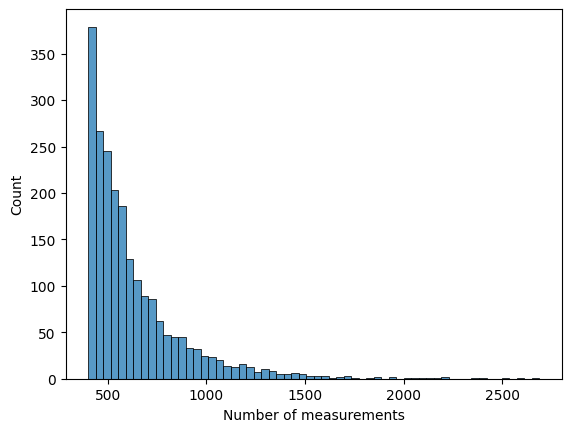

In [10]:
sns.histplot(num_points)
plt.xlabel("Number of measurements")
plt.show()

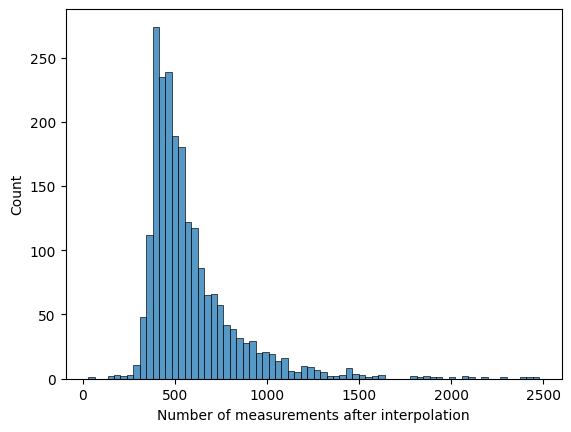

In [11]:
sns.histplot(num_points_after)
plt.xlabel("Number of measurements after interpolation")
plt.show()

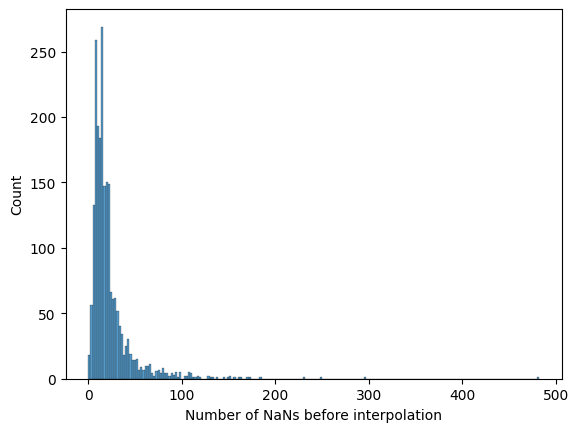

In [12]:
sns.histplot(nan_before)
plt.xlabel("Number of NaNs before interpolation")
plt.show()

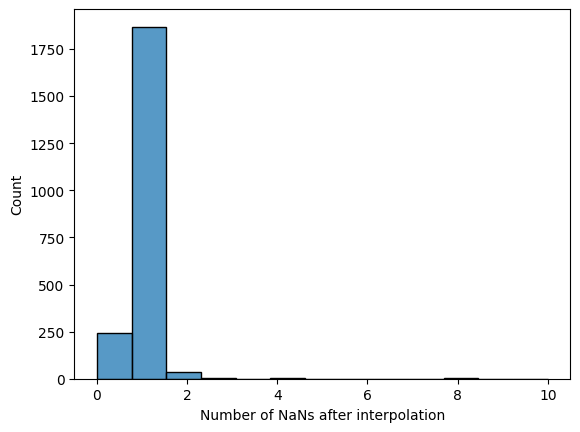

In [13]:
sns.histplot(nan_after)
plt.xlabel("Number of NaNs after interpolation")
plt.show()

## Select first N measurements

In [65]:
import numpy as np
final = []
N = 144
for data in DATA:
    if len(data) < N:
        pass
    else:
        final.append(data[:N])
final = np.asarray(final)
final.shape

(2155, 175)

In [66]:
np.isnan(final).any()

False

In [67]:
np.save('data/heart_rate_linear_interpolate.npy', final)